In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy.spatial import ConvexHull
from sklearn.preprocessing import StandardScaler

In [4]:
with open('../data_for_classifier/AGdata031119.pkl','rb') as f:
    AG_geneIDs, AGdata_outcome, AGdata_clean,X, y, X_train, X_test, y_train, y_test,AG_geneIDs_test, AG_geneIDs_train = pickle.load(f)


X = StandardScaler().fit_transform(AGdata_clean)

y = AGdata_outcome
X_test = X[(AG_geneIDs.Experiment=="T4_PEN")  | 
           (AG_geneIDs.Experiment=="T4_CIP") | (AG_geneIDs.Experiment=='19F_CIP'),:]
X_train = X[(AG_geneIDs.Experiment!="T4_PEN") & 
            (AG_geneIDs.Experiment!="T4_CIP") & (AG_geneIDs.Experiment!='19F_CIP') ,:]

y_test = y[(AG_geneIDs.Experiment=="T4_PEN")  | 
           (AG_geneIDs.Experiment=="T4_CIP") | (AG_geneIDs.Experiment=='19F_CIP') ]
y_train = y[(AG_geneIDs.Experiment!="T4_PEN") & 
            (AG_geneIDs.Experiment!="T4_CIP") & (AG_geneIDs.Experiment!='19F_CIP')]

AG_geneIDs_test = AG_geneIDs.loc[(AG_geneIDs.Experiment=="T4_PEN")  | 
                                 (AG_geneIDs.Experiment=="T4_CIP") | (AG_geneIDs.Experiment=='19F_CIP'),:]
AG_geneIDs_train = AG_geneIDs.loc[(AG_geneIDs.Experiment!="T4_PEN") & 
                                  (AG_geneIDs.Experiment!="T4_CIP") & (AG_geneIDs.Experiment!='19F_CIP'),:]

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [32]:
with open('../predictors/noDropout/predictors_withMOA_RIFtrain.pkl','rb') as f:
    DT_clf, LR_clf, SVM_clf, KNN_clf, RF_clf, MLP_clf = pickle.load(f)

In [46]:
allclf_train = AG_geneIDs_train
allclf_train['DT'] = DT_clf.predict(X_train)
allclf_train['KNN'] = KNN_clf.predict(X_train)
allclf_train['SVC'] = SVM_clf.predict(X_train)
allclf_train['LR'] = LR_clf.predict(X_train)
allclf_train['RF'] = RF_clf.predict(X_train)
allclf_train['MLP'] = MLP_clf.predict(X_train)

allclf_train['consensus_proba'] = allclf_train[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']].mean(axis=1)

allclf_test = AG_geneIDs_test
allclf_test['DT'] = DT_clf.predict(X_test)
allclf_test['KNN'] = KNN_clf.predict(X_test)
allclf_test['SVC'] = SVM_clf.predict(X_test)
allclf_test['LR'] = LR_clf.predict(X_test)
allclf_test['RF'] = RF_clf.predict(X_test)
allclf_test['MLP'] = MLP_clf.predict(X_test)

X_consensus_train = allclf_train[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']]
X_consensus_test = allclf_test[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']]

allclf_train['MajVoteProb'] = allclf_train[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']].sum(axis=1)/6
allclf_test['MajVoteProb'] = allclf_test[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']].sum(axis=1)/6

DT_kappa = cohen_kappa_score(allclf_train.DT, y_train)
KNN_kappa = cohen_kappa_score(allclf_train.KNN, y_train)
SVC_kappa = cohen_kappa_score(allclf_train.SVC, y_train)
LR_kappa = cohen_kappa_score(allclf_train.LR, y_train)
RF_kappa = cohen_kappa_score(allclf_train.RF, y_train)
MLP_kappa = cohen_kappa_score(allclf_train.MLP, y_train)

allclf_train['WtdMajVoteProb'] = (allclf_train.DT * DT_kappa + allclf_train.KNN * KNN_kappa +
                                 allclf_train.SVC*SVC_kappa + allclf_train.LR*LR_kappa +
                                 allclf_train.RF*RF_kappa + allclf_train.MLP*MLP_kappa)/(DT_kappa+KNN_kappa+SVC_kappa+LR_kappa+RF_kappa+MLP_kappa)

allclf_test['WtdMajVoteProb'] = (allclf_test.DT * DT_kappa + allclf_test.KNN * KNN_kappa +
                                 allclf_test.SVC*SVC_kappa + allclf_test.LR*LR_kappa +
                                 allclf_test.RF*RF_kappa + allclf_test.MLP*MLP_kappa)/(DT_kappa+KNN_kappa+SVC_kappa+LR_kappa+RF_kappa+MLP_kappa)


D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

NameError: name 'cohen_kappa_score' is not defined

In [54]:
allclf_train.to_csv('../predictors/URAtrain/noDropout/Consensus_vote_train.csv')
allclf_test.to_csv('../predictors/URAtrain/noDropout/Consensus_vote_test.csv')

In [47]:
#Cons_test = pd.read_csv('../predictors/noDropout/Consensus_vote_test.csv')
#Cons_train = pd.read_csv('../predictors/noDropout/Consensus_vote_train.csv')
Cons_test = allclf_test
Cons_train = allclf_train

In [34]:
DT_train_fpr, DT_train_tpr, _ = roc_curve(y_train, DT_clf.best_estimator_.predict_proba(X_train)[:,1])
DT_test_fpr, DT_test_tpr, _ = roc_curve(y_test, DT_clf.best_estimator_.predict_proba(X_test)[:,1])

DT_train_rocpoints = np.array([DT_train_fpr, DT_train_tpr])
DT_test_rocpoints = np.array([DT_test_fpr, DT_test_tpr])

DT_train_hull = ConvexHull(np.transpose(DT_train_rocpoints))
DT_test_hull = ConvexHull(np.transpose(DT_test_rocpoints))

DT_train_hull = np.sort(DT_train_hull.vertices)
DT_test_hull = np.sort(DT_test_hull.vertices)

In [35]:
LR_train_fpr, LR_train_tpr, _ = roc_curve(y_train, LR_clf.best_estimator_.predict_proba(X_train)[:,1])
LR_test_fpr, LR_test_tpr, _ = roc_curve(y_test, LR_clf.best_estimator_.predict_proba(X_test)[:,1])

LR_train_rocpoints = np.array([LR_train_fpr, LR_train_tpr])
LR_test_rocpoints = np.array([LR_test_fpr, LR_test_tpr])

LR_train_hull = ConvexHull(np.transpose(LR_train_rocpoints))
LR_test_hull = ConvexHull(np.transpose(LR_test_rocpoints))

LR_train_hull = np.sort(LR_train_hull.vertices)
LR_test_hull = np.sort(LR_test_hull.vertices)

In [36]:
SVM_train_fpr, SVM_train_tpr, _ = roc_curve(y_train, SVM_clf.best_estimator_.predict_proba(X_train)[:,1])
SVM_test_fpr, SVM_test_tpr, _ = roc_curve(y_test, SVM_clf.best_estimator_.predict_proba(X_test)[:,1])

SVM_train_rocpoints = np.array([SVM_train_fpr, SVM_train_tpr])
SVM_test_rocpoints = np.array([SVM_test_fpr, SVM_test_tpr])

SVM_train_hull = ConvexHull(np.transpose(SVM_train_rocpoints))
SVM_test_hull = ConvexHull(np.transpose(SVM_test_rocpoints))

SVM_train_hull = np.sort(SVM_train_hull.vertices)
SVM_test_hull = np.sort(SVM_test_hull.vertices)

In [37]:
KNN_train_fpr, KNN_train_tpr, _ = roc_curve(y_train, KNN_clf.best_estimator_.predict_proba(X_train)[:,1])
KNN_test_fpr, KNN_test_tpr, _ = roc_curve(y_test, KNN_clf.best_estimator_.predict_proba(X_test)[:,1])

KNN_train_rocpoints = np.array([KNN_train_fpr, KNN_train_tpr])
KNN_test_rocpoints = np.array([KNN_test_fpr, KNN_test_tpr])

KNN_train_hull = ConvexHull(np.transpose(KNN_train_rocpoints))
KNN_test_hull = ConvexHull(np.transpose(KNN_test_rocpoints))

KNN_train_hull = np.sort(KNN_train_hull.vertices)
KNN_test_hull = np.sort(KNN_test_hull.vertices)

In [38]:
RF_train_fpr, RF_train_tpr, _ = roc_curve(y_train, RF_clf.best_estimator_.predict_proba(X_train)[:,1])
RF_test_fpr, RF_test_tpr, _ = roc_curve(y_test, RF_clf.best_estimator_.predict_proba(X_test)[:,1])

RF_train_rocpoints = np.array([RF_train_fpr, RF_train_tpr])
RF_test_rocpoints = np.array([RF_test_fpr, RF_test_tpr])

RF_train_hull = ConvexHull(np.transpose(RF_train_rocpoints))
RF_test_hull = ConvexHull(np.transpose(RF_test_rocpoints))

RF_train_hull = np.sort(RF_train_hull.vertices)
RF_test_hull = np.sort(RF_test_hull.vertices)

In [40]:
MLP_train_fpr, MLP_train_tpr, _ = roc_curve(y_train, MLP_clf.best_estimator_.predict_proba(X_train)[:,1])
MLP_test_fpr, MLP_test_tpr, _ = roc_curve(y_test, MLP_clf.best_estimator_.predict_proba(X_test)[:,1])

MLP_train_rocpoints = np.array([MLP_train_fpr, MLP_train_tpr])
MLP_test_rocpoints = np.array([MLP_test_fpr, MLP_test_tpr])

MLP_train_hull = ConvexHull(np.transpose(MLP_train_rocpoints))
MLP_test_hull = ConvexHull(np.transpose(MLP_test_rocpoints))

MLP_train_hull = np.sort(MLP_train_hull.vertices)
MLP_test_hull = np.sort(MLP_test_hull.vertices)

In [48]:
CON_train_fpr, CON_train_tpr, _ = roc_curve(y_train, Cons_train['MajVoteProb'])
CON_test_fpr, CON_test_tpr, _ = roc_curve(y_test, Cons_test['MajVoteProb'])

CON_train_rocpoints = np.array([CON_train_fpr, CON_train_tpr])
CON_test_rocpoints = np.array([CON_test_fpr, CON_test_tpr])

CON_train_hull = ConvexHull(np.transpose(CON_train_rocpoints))
CON_test_hull = ConvexHull(np.transpose(CON_test_rocpoints))

CON_train_hull = np.sort(CON_train_hull.vertices)
CON_test_hull = np.sort(CON_test_hull.vertices)


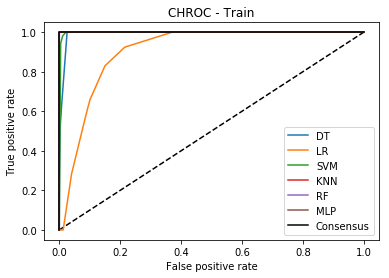

In [31]:
# plot CHROC
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(DT_train_fpr[DT_train_hull], DT_train_tpr[DT_train_hull], label='DT')
plt.plot(LR_train_fpr[LR_train_hull], LR_train_tpr[LR_train_hull], label='LR')
plt.plot(SVM_train_fpr[SVM_train_hull], SVM_train_tpr[SVM_train_hull], label='SVM')
plt.plot(KNN_train_fpr[KNN_train_hull], KNN_train_tpr[KNN_train_hull], label='KNN')
plt.plot(RF_train_fpr[RF_train_hull], RF_train_tpr[RF_train_hull], label='RF')
plt.plot(MLP_train_fpr[MLP_train_hull], MLP_train_tpr[MLP_train_hull], label='MLP')
plt.plot(CON_train_fpr[CON_train_hull], CON_train_tpr[CON_train_hull],'k' ,label='Consensus')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('CHROC - Train')

fig1 = plt.gcf()
plt.show()
fig1.savefig('../predictors/noDropout/CHROC_Train.svg')

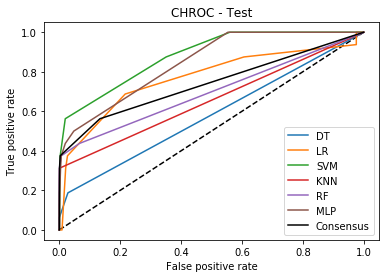

In [49]:
# plot CHROC
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(DT_test_fpr[DT_test_hull], DT_test_tpr[DT_test_hull], label='DT')
plt.plot(LR_test_fpr[LR_test_hull], LR_test_tpr[LR_test_hull], label='LR')
plt.plot(SVM_test_fpr[SVM_test_hull], SVM_test_tpr[SVM_test_hull], label='SVM')
plt.plot(KNN_test_fpr[KNN_test_hull], KNN_test_tpr[KNN_test_hull], label='KNN')
plt.plot(RF_test_fpr[RF_test_hull], RF_test_tpr[RF_test_hull], label='RF')
plt.plot(MLP_test_fpr[MLP_test_hull], MLP_test_tpr[MLP_test_hull], label='MLP')
plt.plot(CON_test_fpr[CON_test_hull], CON_test_tpr[CON_test_hull],'k' ,label='Consensus')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('CHROC - Test')

#plt.xlim(0, 0.01)
#plt.ylim(0,0.5)

fig1 = plt.gcf()
plt.show()
#fig1.savefig('../predictors/noDropout/CHROC_Test.svg')

In [35]:
RF_test_fpr[RF_test_hull], RF_test_tpr[RF_test_hull]

(array([0.00000000e+00, 0.00000000e+00, 3.49650350e-04, 6.64335664e-03,
        6.62587413e-02, 1.00000000e+00]),
 array([0.    , 0.25  , 0.3125, 0.375 , 0.4375, 1.    ]))

In [40]:
#best model for consensus
CON_test_fpr[CON_test_hull][2], CON_test_tpr[CON_test_hull][2]

(0.0006993006993006993, 0.3125)

In [51]:
#isoperformance line's slope (if cost of FP == cost of FN)
m = sum(AG_geneIDs.AG==False)/sum(AG_geneIDs.AG==True)

# y = mx+b
b = CON_test_tpr[CON_test_hull][2] - m * CON_test_fpr[CON_test_hull][2]

In [52]:
xline = [0,1]
yline = [m*xi+b for xi in xline]

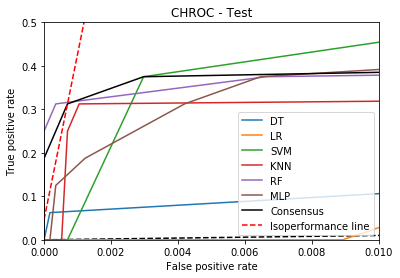

In [55]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(DT_test_fpr[DT_test_hull], DT_test_tpr[DT_test_hull], label='DT')
plt.plot(LR_test_fpr[LR_test_hull], LR_test_tpr[LR_test_hull], label='LR')
plt.plot(SVM_test_fpr[SVM_test_hull], SVM_test_tpr[SVM_test_hull], label='SVM')
plt.plot(KNN_test_fpr[KNN_test_hull], KNN_test_tpr[KNN_test_hull], label='KNN')
plt.plot(RF_test_fpr[RF_test_hull], RF_test_tpr[RF_test_hull], label='RF')
plt.plot(MLP_test_fpr[MLP_test_hull], MLP_test_tpr[MLP_test_hull], label='MLP')
plt.plot(CON_test_fpr[CON_test_hull], CON_test_tpr[CON_test_hull],'k' ,label='Consensus')

plt.plot(xline, yline, 'r--', label="Isoperformance line")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('CHROC - Test')

plt.xlim(0, 0.01)
plt.ylim(0,0.5)

fig1 = plt.gcf()
#plt.show()
fig1.savefig('../predictors/URAtrain/noDropout/CHROC_test_zoom.svg')

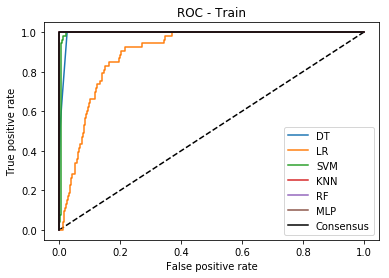

In [29]:
# plot ROC
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(DT_train_fpr, DT_train_tpr, label='DT')
plt.plot(LR_train_fpr, LR_train_tpr, label='LR')
plt.plot(SVM_train_fpr, SVM_train_tpr, label='SVM')
plt.plot(KNN_train_fpr, KNN_train_tpr, label='KNN')
plt.plot(RF_train_fpr, RF_train_tpr, label='RF')
plt.plot(MLP_train_fpr, MLP_train_tpr, label='MLP')
plt.plot(CON_train_fpr, CON_train_tpr,'k' ,label='Consensus')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC - Train')

fig1 = plt.gcf()
plt.show()
fig1.savefig('../predictors/noDropout/ROC_Train.svg')

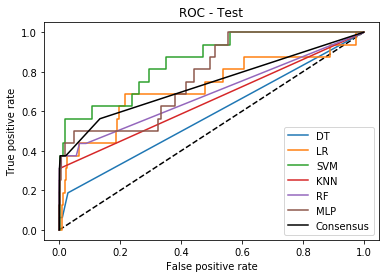

In [28]:
# plot ROC
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(DT_test_fpr, DT_test_tpr, label='DT')
plt.plot(LR_test_fpr, LR_test_tpr, label='LR')
plt.plot(SVM_test_fpr, SVM_test_tpr, label='SVM')
plt.plot(KNN_test_fpr, KNN_test_tpr, label='KNN')
plt.plot(RF_test_fpr, RF_test_tpr, label='RF')
plt.plot(MLP_test_fpr, MLP_test_tpr, label='MLP')
plt.plot(CON_test_fpr, CON_test_tpr,'k' ,label='Consensus')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC - Test')

fig1 = plt.gcf()
plt.show()
fig1.savefig('../predictors/noDropout/ROC_Test.svg')